In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
%%capture
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.27" "trl<0.9.0" peft accelerate bitsandbytes
!pip install huggingface_hub

In [1]:
from huggingface_hub import login
import os

# Try Kaggle secrets first
try:
    from kaggle_secrets import UserSecretsClient
    secrets = UserSecretsClient()
    HF_TOKEN = secrets.get_secret("HF_TOKEN")
    print("Got HF_TOKEN from Kaggle secrets")
except:
    # Try environment variable
    HF_TOKEN = os.getenv("HF_TOKEN")
    if HF_TOKEN:
        print("Got HF_TOKEN from environment")
    else:
        # Manual input
        HF_TOKEN = input("Enter your HuggingFace token: ")

# Login
login(token=HF_TOKEN)
print("Authenticated with HuggingFace!")

Got HF_TOKEN from Kaggle secrets
Authenticated with HuggingFace!


In [2]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("No GPU! Enable in: Settings → Accelerator → GPU")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
VRAM: 15.6 GB


In [41]:
rm -r /kaggle/working/medgemma-chw-merged

rm: cannot remove '/kaggle/working/medgemma-chw-merged': No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [8]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 33.5 MB/s eta 0:00:00:00:0100:01


In [9]:
!pip install trl==0.25.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 13.0 MB/s eta 0:00:0000:01


In [10]:
import gc
def clear_memory():
    gc.collect()
    for i in range(torch.cuda.device_count()):
        with torch.cuda.device(i):
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

In [11]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

MODEL_NAME = "google/medgemma-1.5-4b-it"

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

print(f"🔄 Loading {MODEL_NAME}...")
print("   This takes 3-5 minutes...")

clear_memory()

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    token=HF_TOKEN,
    trust_remote_code=True,
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",  # Use all available GPUs
    token=HF_TOKEN,
    trust_remote_code=True,
    dtype=torch.float16,
)

# Set padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id

print("✅ Model loaded!")
print(f"   Memory: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")

🔄 Loading google/medgemma-1.5-4b-it...
   This takes 3-5 minutes...


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

2026-02-12 07:50:36.000498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770882636.222343      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770882636.278840      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770882636.793382      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770882636.793411      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770882636.793414      55 computation_placer.cc:177] computation placer alr

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

✅ Model loaded!
   Memory: 0.15 GB


In [12]:

# Check memory after loading
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1e9
    print(f"   GPU memory used: {allocated:.2f} GB")

   GPU memory used: 0.15 GB


In [13]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Prepare model for training
model = prepare_model_for_kbit_training(model)

# LoRA config - targeting text model layers only
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
)

model = get_peft_model(model, lora_config)

# Count parameters
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"✅ LoRA applied: {trainable:,} trainable ({100*trainable/total:.2f}%)")
model.print_trainable_parameters()

✅ LoRA applied: 32,788,480 trainable (1.30%)
trainable params: 32,788,480 || all params: 4,332,867,952 || trainable%: 0.7567


In [14]:
# Check if model has trainable params
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable params: {trainable:,}")
if trainable == 0:
    print("❌ No trainable params! Run the LoRA cell again.")
else:
    print("✅ Model has trainable adapters")

Trainable params: 32,788,480
✅ Model has trainable adapters


In [25]:
from datasets import Dataset
import json

# ━━━ UPDATE THESE PATHS for Kaggle ━━━
TRAIN_PATH = "/kaggle/input/medgemma-custom-chw-dataset/training_data_tool_aligned_train.jsonl"
TEST_PATH = "/kaggle/input/medgemma-custom-chw-dataset/training_data_tool_aligned_test.jsonl"

def load_data(filepath):
    """Load JSONL, ensuring all fields are strings for Dataset compatibility."""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            record = json.loads(line)
            response = record.get('response', '')
            if isinstance(response, dict):
                response = json.dumps(response)
            data.append({
                'instruction': str(record.get('instruction', '')),
                'response': str(response),
                'category': str(record.get('category', 'unknown'))
            })
    return data


def validate_json_responses(data):
    """Filter out examples with unparseable JSON responses."""
    valid = []
    skipped = 0
    for example in data:
        resp = example['response'].strip()
        if resp.startswith('{'):
            try:
                json.loads(resp)
                valid.append(example)
            except json.JSONDecodeError:
                skipped += 1
        else:
            valid.append(example)
    if skipped:
        print(f"Filtered {skipped} examples with invalid JSON")
    return valid


# Load and validate
train_data = load_data(TRAIN_PATH)
test_data = load_data(TEST_PATH)

print(f"Raw: {len(train_data)} train, {len(test_data)} test")

train_data = validate_json_responses(train_data)
test_data = validate_json_responses(test_data)

print(f"📊 After validation: {len(train_data)} train, {len(test_data)} test")

# Show category distribution
from collections import Counter
cats = Counter(d['category'] for d in train_data)
print("\nTraining categories:")
for cat, count in cats.most_common():
    print(f"  {cat}: {count}")

Raw: 1200 train, 180 test
📊 After validation: 1200 train, 180 test

Training categories:
  referral_advisor: 200
  emergency_protocol: 200
  risk_assessor: 200
  soap_note: 200
  treatment_advisor: 200
  clinical_assessment: 200


In [ ]:
print(training_data)

In [ ]:
# Show a sample example
print("Sample training example:")
print("=" * 50)
sample = training_data[0]
print(f"Category: {sample.get('category', 'N/A')}")
print(f"\nInstruction:\n{sample['instruction'][:300]}...")
print(f"\nResponse:\n{str(sample['response'])[:300]}...")

In [26]:
def format_example(example):
    """
    Format using tokenizer.apply_chat_template() — NOT manual string building.
    This ensures training data matches MedGemma's native chat format exactly.
    """
    instruction = example['instruction']
    response = example['response']

    messages = [
        {"role": "user", "content": instruction},
        {"role": "model", "content": response},
    ]

    try:
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False,
        )
    except Exception:
        # Fallback to manual template
        text = f"<bos><start_of_turn>user\n{instruction}<end_of_turn>\n<start_of_turn>model\n{response}<end_of_turn><eos>"

    return {"text": text}


# Create datasets and apply formatting
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

train_dataset = train_dataset.map(format_example, remove_columns=train_dataset.column_names)
test_dataset = test_dataset.map(format_example, remove_columns=test_dataset.column_names)

print(f"✅ Datasets formatted: {len(train_dataset)} train, {len(test_dataset)} test")
print(f"\nSample (first 300 chars):\n{train_dataset[0]['text'][:300]}...")


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

✅ Datasets formatted: 1200 train, 180 test

Sample (first 300 chars):
<bos><start_of_turn>user
ASSESSMENT: {"triage_level": "URGENT", "differential_diagnoses": ["Acute appendicitis"], "red_flags": ["RLQ pain with fever"]}, FACILITIES: District Hospital, Surgical Center

Return JSON only: {"referral_needed": true, "referral_type": "specialty", "referral_urgency": "IMME...


In [ ]:
!pip install trl

In [27]:
from trl import SFTTrainer, SFTConfig
MAX_LENGTH = 2048 
clear_memory()

training_args = SFTConfig(
    output_dir="/kaggle/working/medgemma-chw-finetuned",

    # ── Training hyperparameters ──
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    max_steps=600,

    # ── Learning rate schedule ──
    warmup_ratio=0.05,
    learning_rate=1.5e-4,
    lr_scheduler_type="cosine",
    weight_decay=0.01,

    # ── Optimization ──
    fp16=True,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    optim="paged_adamw_8bit",

    # ── Logging ──
    logging_steps=25,
    report_to="none",

    # ── ✅ VALIDATION LOSS — NEW ──
    eval_strategy="steps",          # Evaluate periodically
    eval_steps=50,                  # Every 50 training steps
    per_device_eval_batch_size=2,   # Can be larger than train batch

    # ── ✅ BEST MODEL SELECTION — NEW ──
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,        # Lower eval_loss = better

    # ── Save ──
    save_steps=100,
    save_total_limit=3,

    # ── Data ──
    max_length=MAX_LENGTH,
    packing=False,
)

trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,      # ✅ Validation set — NEW
    args=training_args,
    formatting_func=lambda x: x["text"],
)

print("✅ Trainer configured WITH validation loss tracking")
print(f"   Training steps: {training_args.max_steps}")
print(f"   Eval every {training_args.eval_steps} steps")
print(f"   MAX_LENGTH: {MAX_LENGTH}")

Applying formatting function to train dataset:   0%|          | 0/1200 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/1200 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1200 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1200 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/180 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/180 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/180 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/180 [00:00<?, ? examples/s]

✅ Trainer configured WITH validation loss tracking
   Training steps: 600
   Eval every 50 steps
   MAX_LENGTH: 2048


In [22]:
import trl
print(f"TRL Version: {trl.__version__}")

TRL Version: 0.25.1


In [ ]:
 [code] {"execution":{"iopub.status.busy":"2026-01-24T11:16:50.926005Z","iopub.execute_input":"2026-01-24T11:16:50.926614Z","iopub.status.idle":"2026-01-24T13:49:58.018519Z","shell.execute_reply.started":"2026-01-24T11:16:50.926582Z","shell.execute_reply":"2026-01-24T13:49:58.017848Z"},"jupyter":{"outputs_hidden":false}}

In [28]:
print("🚀 Starting training...")
print(f"   {len(train_dataset):,} train / {len(test_dataset):,} eval examples")
print(f"   {training_args.max_steps} steps, eval every {training_args.eval_steps}")

train_result = trainer.train()

print("\n" + "=" * 50)
print("✅ Training complete!")
print("=" * 50)

# Print final metrics
metrics = train_result.metrics
print(f"\n📊 Final Training Loss: {metrics.get('train_loss', 'N/A'):.4f}")
print(f"   Total Training Time: {metrics.get('train_runtime', 0):.0f}s")
print(f"   Samples/sec: {metrics.get('train_samples_per_second', 0):.1f}")

# Run final evaluation
eval_metrics = trainer.evaluate()
print(f"\n📊 Final Validation Loss: {eval_metrics.get('eval_loss', 'N/A'):.4f}")
print(f"   Eval Perplexity: {torch.exp(torch.tensor(eval_metrics.get('eval_loss', 0))):.2f}")

# Save the best model
trainer.save_model("/kaggle/working/medgemma-chw-finetuned-final")
print("\n💾 Best model saved to ./medgemma-chw-finetuned-final")

🚀 Starting training...
   1,200 train / 180 eval examples
   600 steps, eval every 50


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
50,0.333500,0.088318,0.099202,176869.000000,0.969786
100,0.042100,0.044302,0.039869,356151.000000,0.981239
150,0.042200,0.039107,0.040575,532540.000000,0.981991
200,0.037700,0.036185,0.035469,709148.000000,0.983229
250,0.036100,0.036048,0.037317,887130.000000,0.982590
300,0.034400,0.034701,0.034284,1065080.000000,0.983352
350,0.033700,0.035406,0.035481,1242255.000000,0.982732
400,0.032900,0.036256,0.032422,1419069.000000,0.982892
450,0.032500,0.035750,0.032563,1597620.000000,0.983313
500,0.030900,0.037980,0.031102,1773669.000000,0.982975



✅ Training complete!

📊 Final Training Loss: 0.1266
   Total Training Time: 9750s
   Samples/sec: 1.0



📊 Final Validation Loss: 0.0347
   Eval Perplexity: 1.04

💾 Best model saved to ./medgemma-chw-finetuned-final


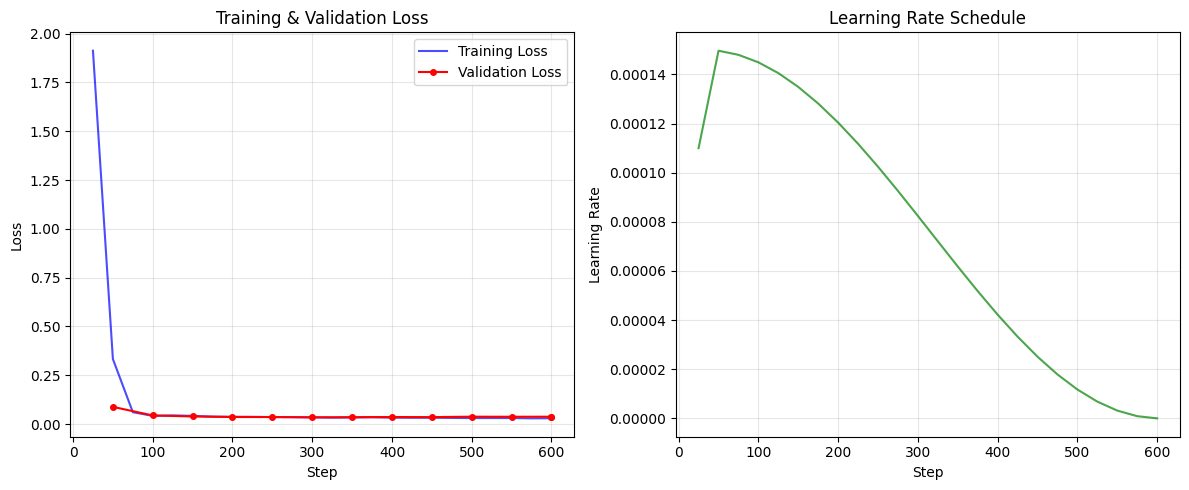


📊 Loss Summary:
  Step |   Train Loss |     Val Loss
------------------------------------
    25 |       1.9128 |            —
    50 |       0.3335 |       0.0883
    75 |       0.0611 |            —
   100 |       0.0421 |       0.0443
   125 |       0.0446 |            —
   150 |       0.0422 |       0.0391
   175 |       0.0385 |            —
   200 |       0.0377 |       0.0362
   225 |       0.0373 |            —
   250 |       0.0361 |       0.0360
   275 |       0.0355 |            —
   300 |       0.0344 |       0.0347
   325 |       0.0329 |            —
   350 |       0.0337 |       0.0354
   375 |       0.0350 |            —
   400 |       0.0329 |       0.0363
   425 |       0.0324 |            —
   450 |       0.0325 |       0.0358
   475 |       0.0316 |            —
   500 |       0.0309 |       0.0380
   525 |       0.0311 |            —
   550 |       0.0310 |       0.0375
   575 |       0.0295 |            —
   600 |       0.0300 |       0.0347

✅ Validation loss im

In [29]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

# Extract training loss
train_steps = [entry['step'] for entry in log_history if 'loss' in entry]
train_losses = [entry['loss'] for entry in log_history if 'loss' in entry]

# Extract validation loss
eval_steps = [entry['step'] for entry in log_history if 'eval_loss' in entry]
eval_losses = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]

plt.figure(figsize=(12, 5))

# Plot 1: Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_losses, 'b-', alpha=0.7, label='Training Loss')
plt.plot(eval_steps, eval_losses, 'r-o', markersize=4, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Learning rate
lr_steps = [entry['step'] for entry in log_history if 'learning_rate' in entry]
lr_values = [entry['learning_rate'] for entry in log_history if 'learning_rate' in entry]

plt.subplot(1, 2, 2)
plt.plot(lr_steps, lr_values, 'g-', alpha=0.7)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary table
print("\n📊 Loss Summary:")
print(f"{'Step':>6} | {'Train Loss':>12} | {'Val Loss':>12}")
print("-" * 36)

# Merge and sort
all_entries = {}
for entry in log_history:
    step = entry.get('step', 0)
    if step not in all_entries:
        all_entries[step] = {}
    if 'loss' in entry:
        all_entries[step]['train'] = entry['loss']
    if 'eval_loss' in entry:
        all_entries[step]['eval'] = entry['eval_loss']

for step in sorted(all_entries.keys()):
    train_l = all_entries[step].get('train', '')
    eval_l = all_entries[step].get('eval', '')
    train_str = f"{train_l:.4f}" if train_l != '' else "—"
    eval_str = f"{eval_l:.4f}" if eval_l != '' else "—"
    if train_l != '' or eval_l != '':
        print(f"{step:>6} | {train_str:>12} | {eval_str:>12}")

# Overfitting check
if len(eval_losses) >= 3:
    last_3_eval = eval_losses[-3:]
    if all(last_3_eval[i] < last_3_eval[i+1] for i in range(len(last_3_eval)-1)):
        print("\n⚠️  Warning: Validation loss INCREASING over last 3 evals — possible overfitting!")
        print("   Consider: fewer steps, lower learning rate, or more data")
    elif eval_losses[-1] < eval_losses[0]:
        print(f"\n✅ Validation loss improved: {eval_losses[0]:.4f} → {eval_losses[-1]:.4f}")
    else:
        print(f"\n📊 Validation loss: start={eval_losses[0]:.4f}, end={eval_losses[-1]:.4f}")

In [30]:
import re

# Expected keys for each tool category
EXPECTED_KEYS = {
    'clinical_assessment': {'triage_level', 'differential_diagnoses', 'red_flags', 'recommended_investigations'},
    'soap_note': {'subjective', 'objective', 'assessment', 'plan'},
    'treatment_advisor': {'medications', 'care_plan_goals'},
    'risk_assessor': {'risk_level', 'risk_factors', 'chronic_conditions', 'recommendations'},
    'referral_advisor': {'referral_needed', 'referral_type', 'referral_urgency'},
    'emergency_protocol': {'emergency_level', 'immediate_actions', 'call_for_help', 'monitoring'},
}

# Reload test data with categories for evaluation
raw_test_data = load_data(TEST_PATH)

# Sample up to 30 examples for generation evaluation (to save time)
eval_sample = raw_test_data[:30]

model.eval()

results = {
    'total': 0,
    'json_valid': 0,
    'schema_correct': 0,
    'categories': Counter(),
    'errors': [],
}

print("🔍 Evaluating model outputs on test samples...\n")

for i, example in enumerate(eval_sample):
    category = example['category']
    instruction = example['instruction']
    
    # Format input using chat template
    messages = [{"role": "user", "content": instruction}]
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=512,
            temperature=0.1,
            do_sample=True,
            top_p=0.9,
        )
    
    # Decode only the generated part
    generated = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
    generated = generated.strip()
    
    # Remove any trailing chat artifacts
    generated = re.sub(r'<[^>]+>', '', generated).strip()
    
    results['total'] += 1
    results['categories'][category] += 1
    
    # Check 1: Is it valid JSON?
    try:
        parsed = json.loads(generated)
        results['json_valid'] += 1
        
        # Check 2: Does it have the expected schema keys?
        expected = EXPECTED_KEYS.get(category, set())
        if expected and expected.issubset(set(parsed.keys())):
            results['schema_correct'] += 1
        elif expected:
            missing = expected - set(parsed.keys())
            results['errors'].append(f"  [{category}] Missing keys: {missing}")

    except json.JSONDecodeError:
        results['errors'].append(f"  [{category}] Invalid JSON: {generated[:80]}...")
    
    # Progress
    if (i + 1) % 10 == 0:
        print(f"  Evaluated {i+1}/{len(eval_sample)}...")

# Print results
print("\n" + "=" * 50)
print("📊 POST-TRAINING EVALUATION RESULTS")
print("=" * 50)
print(f"\n  Total samples evaluated: {results['total']}")
print(f"  ✅ JSON valid: {results['json_valid']}/{results['total']} ({100*results['json_valid']/max(results['total'],1):.1f}%)")
print(f"  ✅ Schema correct: {results['schema_correct']}/{results['total']} ({100*results['schema_correct']/max(results['total'],1):.1f}%)")

if results['errors']:
    print(f"\n  ⚠️  Errors ({len(results['errors'])}):")
    for err in results['errors'][:10]:
        print(f"    {err}")

print(f"\n  Eval Perplexity: {torch.exp(torch.tensor(eval_metrics.get('eval_loss', 0))):.2f}")

print("\n  Per-category counts:")
for cat, count in results['categories'].most_common():
    print(f"    {cat}: {count}")

🔍 Evaluating model outputs on test samples...

  Evaluated 10/30...
  Evaluated 20/30...
  Evaluated 30/30...

📊 POST-TRAINING EVALUATION RESULTS

  Total samples evaluated: 30
  ✅ JSON valid: 30/30 (100.0%)
  ✅ Schema correct: 30/30 (100.0%)

  Eval Perplexity: 1.04

  Per-category counts:
    clinical_assessment: 7
    emergency_protocol: 6
    treatment_advisor: 5
    soap_note: 5
    risk_assessor: 4
    referral_advisor: 3


In [31]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from pathlib import Path

BASE_MODEL = "google/medgemma-1.5-4b-it"
LORA_ADAPTER_PATH = "/kaggle/working/medgemma-chw-finetuned-final"
MERGED_MODEL_PATH = "/kaggle/working/medgemma-chw-merged"

clear_memory()

print("🔄 Loading base model (full precision for merging)...")
base_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, token=HF_TOKEN, trust_remote_code=True)
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    device_map="auto",
    token=HF_TOKEN,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
)

print("🔄 Loading LoRA adapters...")
peft_model = PeftModel.from_pretrained(base_model, LORA_ADAPTER_PATH)

print("🔄 Merging adapters with base model...")
merged_model = peft_model.merge_and_unload()

os.makedirs(MERGED_MODEL_PATH, exist_ok=True)
print(f"💾 Saving merged model to {MERGED_MODEL_PATH}...")
merged_model.save_pretrained(MERGED_MODEL_PATH, safe_serialization=True, max_shard_size="2GB")
base_tokenizer.save_pretrained(MERGED_MODEL_PATH)

total_size = sum(f.stat().st_size for f in Path(MERGED_MODEL_PATH).rglob('*') if f.is_file())
print(f"✅ Merged model saved! Total size: {total_size/1e9:.2f} GB")

del peft_model, merged_model, base_model
clear_memory()


🔄 Loading base model (full precision for merging)...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

🔄 Loading LoRA adapters...
🔄 Merging adapters with base model...
💾 Saving merged model to /kaggle/working/medgemma-chw-merged...
✅ Merged model saved! Total size: 8.64 GB


In [ ]:
print("🔄 Loading LoRA adapters...")
model = PeftModel.from_pretrained(base_model, LORA_ADAPTER_PATH)

print("🔄 Merging adapters with base model...")
merged_model = model.merge_and_unload()

print("✅ Merge complete!")

In [ ]:
import os

os.makedirs(MERGED_MODEL_PATH, exist_ok=True)

print(f"💾 Saving merged model to {MERGED_MODEL_PATH}...")
print("   This takes 5-10 minutes...")

merged_model.save_pretrained(
    MERGED_MODEL_PATH, 
    safe_serialization=True,
    max_shard_size="2GB"
)
tokenizer.save_pretrained(MERGED_MODEL_PATH)

# Calculate size
total_size = sum(f.stat().st_size for f in Path(MERGED_MODEL_PATH).rglob('*') if f.is_file())
print(f"✅ Saved! Total size: {total_size/1e9:.2f} GB")

# List files
print("\nFiles created:")
for f in sorted(Path(MERGED_MODEL_PATH).iterdir()):
    size = f.stat().st_size / 1e6
    print(f"  {f.name}: {size:.1f} MB")

# Clear GPU memory
del model, merged_model, base_model
clear_memory()

In [ ]:
!git clone --depth 1 https://github.com/ggerganov/llama.cpp

In [33]:
%cd /kaggle/working/llama.cpp

/kaggle/working/llama.cpp


In [38]:
import subprocess

GGUF_OUTPUT = "/kaggle/working/medgemma-chw-f16.gguf"

print("🔄 Converting to GGUF format (F16)...")
print("   This takes 10-15 minutes...")

# Run conversion
result = subprocess.run([
    "python", "convert_hf_to_gguf.py",
    MERGED_MODEL_PATH,
    "--outfile", GGUF_OUTPUT,
    "--outtype", "f16"
], capture_output=True, text=True)

print(result.stdout)
if result.returncode != 0:
    print(f"Error: {result.stderr}")
else:
    size_gb = Path(GGUF_OUTPUT).stat().st_size / 1e9
    print(f"✅ Created {GGUF_OUTPUT} ({size_gb:.2f} GB)")

🔄 Converting to GGUF format (F16)...
   This takes 10-15 minutes...

✅ Created /kaggle/working/medgemma-chw-f16.gguf (7.77 GB)


In [37]:
!cmake -B build && cmake --build build --config Release -j 4

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


CMAKE_BUILD_TYPE=Release
-- Warning: ccache not found - consider installing it for faster compilation or disable this warning with GGML_CCACHE=OFF
-- CMAKE_SYSTEM_PROCESSOR: x86_64
-- GGML_SYSTEM_ARCH: x86
-- Including CPU backend
-- x86 detected
-- Adding CPU backend variant ggml-cpu: -march=native 
-- ggml version: 0.9.5
-- ggml commit:  8f91ca5-dirty
-- OpenSSL found: 3.0.2
-- Generating embedded license file for target: common
-- Configuring done (0.1s)
-- Generating done (0.3s)
-- Build files have been written to: /kaggle/working/llama.cpp/build
[  0%] Built target build_info
[  0%] Built target sha256
[  1%] Built target cpp-httplib
[  4%] Built target ggml-base
[  5%] Built target xxhash
[  6%] Built target sha1
[  6%] Built target llama-llava-cli
[  6%] Built target llama-minicpmv-cli
[  6%] Built target llama-gemma3-cli
[  7%] Built target llama-qwen2vl-cli
[ 10%] Built target ggml-cpu
[ 10%] Built target ggml
[ 10%] Built target llama-gguf
[ 11%] Built target llama-gguf-hash


In [42]:
import subprocess

# Clone llama.cpp if not already done
# !git clone --depth 1 https://github.com/ggerganov/llama.cpp
# %cd /kaggle/working/llama.cpp
# !cmake -B build && cmake --build build --config Release -j 4

GGUF_OUTPUT = "/kaggle/working/medgemma-chw-f16.gguf"
QUANTIZED_OUTPUT = "/kaggle/working/medgemma-chw-q4_k_m.gguf"

# print("🔄 Converting to GGUF format (F16)...")
# result = subprocess.run([
#     "python", "convert_hf_to_gguf.py",
#     MERGED_MODEL_PATH,
#     "--outfile", GGUF_OUTPUT,
#     "--outtype", "f16"
# ], capture_output=True, text=True)

# if result.returncode == 0:
#     size_gb = Path(GGUF_OUTPUT).stat().st_size / 1e9
#     print(f"✅ F16 GGUF: {size_gb:.2f} GB")
# else:
#     print(f"Error: {result.stderr}")

print("🔄 Quantizing to Q4_K_M...")
result = subprocess.run([
    "build/bin/llama-quantize",
    GGUF_OUTPUT,
    QUANTIZED_OUTPUT,
    "Q4_K_M"
], capture_output=True, text=True)

if result.returncode == 0:
    size_gb = Path(QUANTIZED_OUTPUT).stat().st_size / 1e9
    print(f"✅ Q4_K_M GGUF: {size_gb:.2f} GB — Ready for Ollama!")
else:
    print(f"Error: {result.stderr}")

🔄 Quantizing to Q4_K_M...
✅ Q4_K_M GGUF: 2.49 GB — Ready for Ollama!
